In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler as SS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from config_store import features, targetDataSet
from utility_functions import dataSetSplit, doKFold, score

In [2]:
# Import and preview data set
data = pd.read_csv(targetDataSet)
data.head()

,Website,Packets,Bytes,Packets A → B,Bytes A → B,Packets B → A,Bytes B → A,Duration,Bits/s A → B,Bits/s B → A
0,0,1,712,1,712,0,0,16.763719,339,0
1,0,1,718,1,718,0,0,10.784664,532,0
2,0,1,889,1,889,0,0,4.927569,1443,0
3,0,1,712,1,712,0,0,13.479684,422,0
4,0,1,718,1,718,0,0,12.706807,452,0


In [3]:
# Separate data set using test/train split
XTrain, XTest, yTrain, yTest = dataSetSplit(data.drop(columns = ["Website"]).values, data["Website"].values)

# Scale data
ss = SS()
XTrainScaled = ss.fit_transform(XTrain)
XTestScaled = ss.transform(XTest)

In [4]:
# Perform k-fold to optimize alpha hyperparameter
alphaRange = np.linspace(0, 0.3, 1000)

# Hold k-fold result for each possible k neighbor value
train = []
test = []
    
for alpha in alphaRange:
    rid_reg = Lasso(alpha=alpha)
    trainResult, testResult = doKFold(rid_reg, XTrainScaled, yTrain)
        
    train.append(np.mean(trainResult))
    test.append(np.mean(testResult))

c:\Users\okisn\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\okisn\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\okisn\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e+02, tolerance: 7.028e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model 

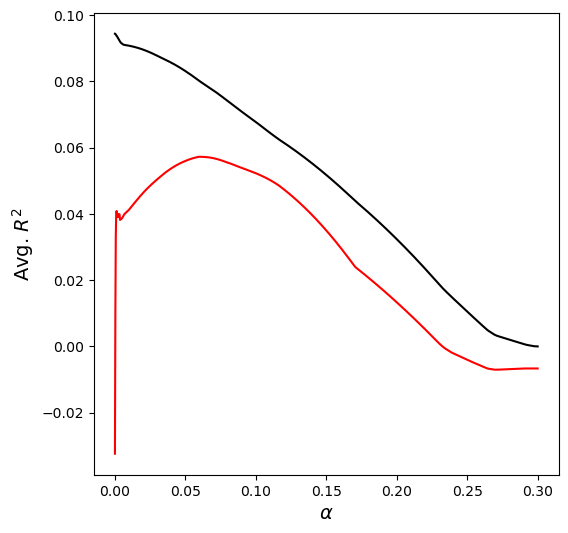

In [5]:
plt.figure(figsize=(6,6))
plt.plot(alphaRange, train, color='k', label='Training')
plt.plot(alphaRange, test, color='r', label='Testing')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('Avg. $R^2$', fontsize=14)
plt.show()

In [6]:
# Get optimal hyperparameter for lasso
maxIndex = (test == np.max(test))
print(alphaRange[maxIndex])
print(np.max(test))
print(np.max(train))

[0.06036036]
0.05726242758833916
0.09442216481319712


In [7]:
# Final lasso model
lasso = Lasso(alpha=alphaRange[maxIndex][0])
lasso.fit(XTrainScaled, yTrain)

Lasso(alpha=0.060360360360360354)

In [8]:
# Score model
print("Model scores:")
score(lasso, XTrainScaled, yTrain, XTestScaled, yTest)

Model scores:
Training score: 0.0787856237166824
Testing score: 0.09936502863628216


In [9]:
# Report feature importance
print("Feature importance:")
for i in range(len(lasso.coef_)):
    print("{} \t{:>30}".format(features[i], lasso.coef_[i]))

Feature importance:
Packets 	                          -0.0
Bytes 	                          -0.0
Packets A → B 	           -0.2361128244168128
Bytes A → B 	                           0.0
Packets B → A 	                          -0.0
Bytes B → A 	                          -0.0
Duration 	            0.2271715527307656
Bits/s A → B 	          0.048485585253564216
Bits/s B → A 	                          -0.0


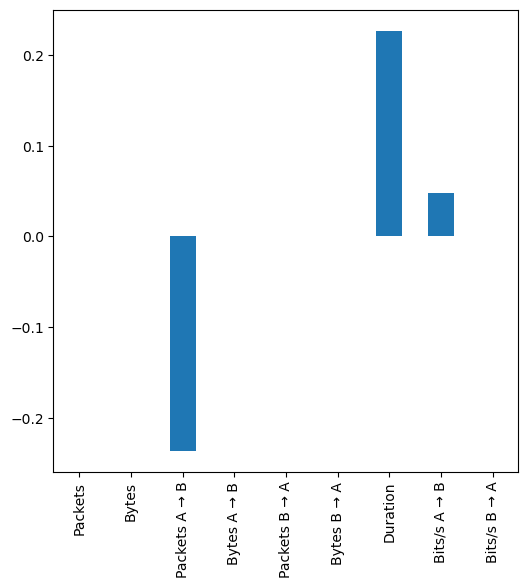

In [10]:
lassoCoef = pd.Series(lasso.coef_)
plt.figure(figsize=(6,6))
lassoCoef.plot.bar()
plt.xticks(np.array(range(0, 9)), features)
plt.show()

In [11]:
alphaRange = np.linspace(0, 0.3, 100)
lassoCoef = []
for alpha in alphaRange:
    lasso = Lasso(alpha = alpha)
    lasso.fit(XTrainScaled, yTrain)
    lassoCoef.append(lasso.coef_)

c:\Users\okisn\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\okisn\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\okisn\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.575e+02, tolerance: 7.878e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model 

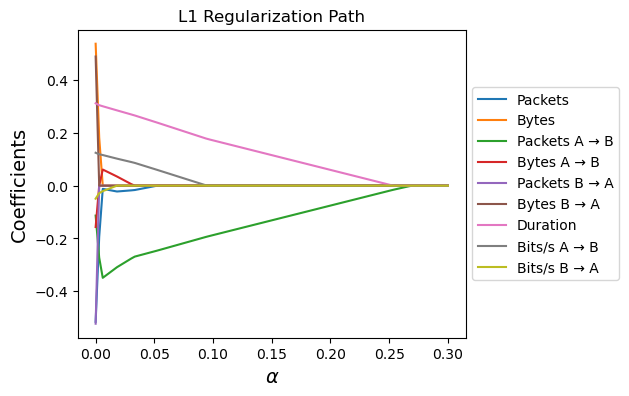

In [13]:
plt.figure(figsize=(5,4))
plt.plot(alphaRange, lassoCoef)
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('Coefficients', fontsize=14)
plt.legend(data.drop(columns = "Website"), bbox_to_anchor=[1,0.5], loc='center left')
plt.title("L1 Regularization Path")
plt.show()

# Extra Data Analysis

In [14]:
# Check correlation of variables
data.corr()

,Website,Packets,Bytes,Packets A → B,Bytes A → B,Packets B → A,Bytes B → A,Duration,Bits/s A → B,Bits/s B → A
Website,1.000000,-0.029261,0.043369,-0.203511,-0.051300,0.052957,0.055845,0.195790,0.004201,0.058970
Packets,-0.029261,1.000000,0.936578,0.022004,-0.150549,0.919306,0.912883,-0.041908,-0.039353,0.552012
Bytes,0.043369,0.936578,1.000000,-0.186987,-0.087739,0.942720,0.952345,-0.050029,-0.017568,0.584859
Packets A → B,-0.203511,0.022004,-0.186987,1.000000,0.652051,-0.373220,-0.372713,0.104297,0.070009,-0.439596
Bytes A → B,-0.051300,-0.150549,-0.087739,0.652051,1.000000,-0.396378,-0.387403,0.112907,0.145298,-0.467342
Packets B → A,0.052957,0.919306,0.942720,-0.373220,-0.396378,1.000000,0.993840,-0.079945,-0.064077,0.685292
Bytes B → A,0.055845,0.912883,0.952345,-0.372713,-0.387403,0.993840,1.000000,-0.080873,-0.060750,0.684377
Duration,0.195790,-0.041908,-0.050029,0.104297,0.112907,-0.079945,-0.080873,1.000000,-0.227898,-0.069038
Bits/s A → B,0.004201,-0.039353,-0.017568,0.070009,0.145298,-0.064077,-0.060750,-0.227898,1.000000,-0.024948
Bits/s B → A,0.058970,0.552012,0.584859,-0.439596,-0.467342,0.685292,0.684377,-0.069038,-0.024948,1.000000


<Axes: >

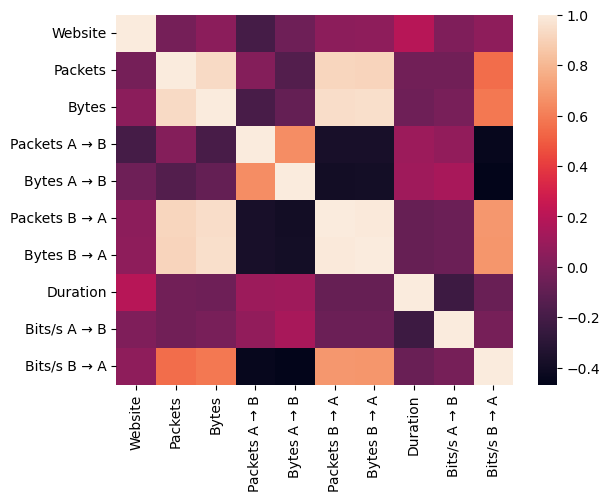

In [15]:
# Create correlation heatmap
sns.heatmap(data.corr())

In [13]:
# Make new scaled X set
XData = SS().fit_transform(data.drop(columns = ["Website"]))

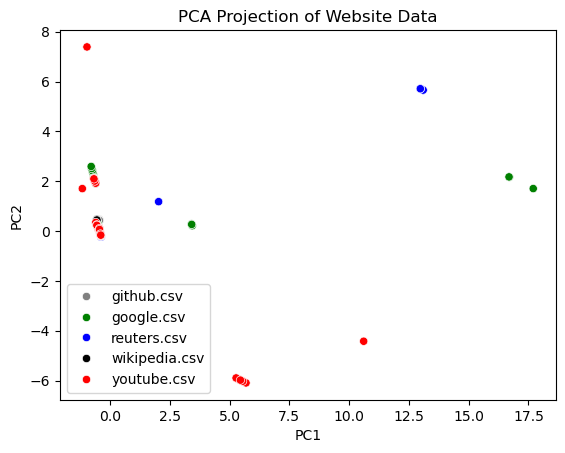

In [16]:
# Make PCA
pca = PCA()
XPCA = pca.fit_transform(XData)
pcaData = pd.DataFrame(XPCA[:, :2], columns = ["PC1", "PC2"])
pcaData["Website"] = data["Website"]

#  Plot PCA
ax = sns.scatterplot(data = pcaData, x = "PC1", y = "PC2", hue = "Website", palette = ["gray", "green", "blue", "black", "red"])
plt.legend(ax.get_legend_handles_labels()[0], ["github.csv", "google.csv", "reuters.csv", "wikipedia.csv", "youtube.csv"])
plt.title("PCA Projection of Website Data")
plt.show()

In [21]:
pcaData[pcaData['Website'] == 0].describe()

,PC1,PC2,Website
count,100.000000,100.000000,100.0
mean,-0.382653,-0.111602,0.0
std,0.023201,0.208082,0.0
min,-0.455633,-0.212585,0.0
25%,-0.377998,-0.201489,0.0
50%,-0.373568,-0.188736,0.0
75%,-0.370797,-0.175273,0.0
max,-0.368040,0.470507,0.0


In [22]:
pcaData[pcaData['Website'] == 1].describe()

,PC1,PC2,Website
count,102.000000,102.000000,102.0
mean,0.157443,0.359998,1.0
std,3.027427,0.817016,0.0
min,-0.784533,-0.210334,1.0
25%,-0.467459,-0.082270,1.0
50%,-0.427949,-0.001407,1.0
75%,-0.400817,0.259623,1.0
max,17.699670,2.593295,1.0


In [23]:
pcaData[pcaData['Website'] == 2].describe()

,PC1,PC2,Website
count,102.000000,102.000000,102.0
mean,0.291991,0.171419,2.0
std,2.920456,1.266645,0.0
min,-0.437161,-0.231151,2.0
25%,-0.409537,-0.188679,2.0
50%,-0.377798,-0.165088,2.0
75%,-0.372002,-0.006998,2.0
max,13.097765,5.712528,2.0


In [24]:
pcaData[pcaData['Website'] == 3].describe()

,PC1,PC2,Website
count,100.000000,100.000000,100.0
mean,-0.407583,-0.061269,3.0
std,0.036337,0.136804,0.0
min,-0.551304,-0.188466,3.0
25%,-0.438465,-0.169794,3.0
50%,-0.386331,-0.150855,3.0
75%,-0.377268,0.059453,3.0
max,-0.371317,0.469965,3.0


In [25]:
pcaData[pcaData['Website'] == 4].describe()

,PC1,PC2,Website
count,102.000000,102.000000,102.0
mean,0.325307,-0.361935,4.0
std,2.180874,2.354988,0.0
min,-1.155052,-6.093684,4.0
25%,-0.455898,-0.117016,4.0
50%,-0.422343,-0.055025,4.0
75%,-0.401471,0.109596,4.0
max,10.609402,7.389926,4.0


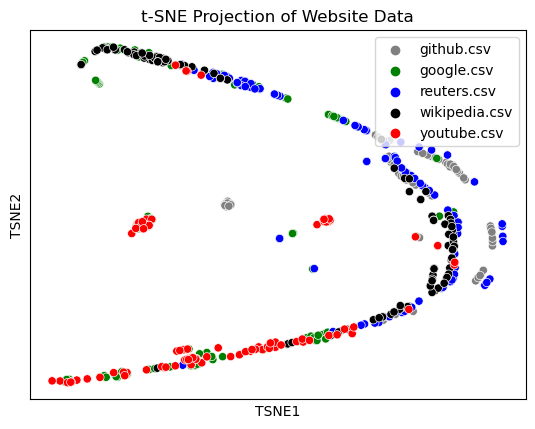

In [18]:
# Make TSNE
tsne = TSNE()
XTSNE = tsne.fit_transform(XData)
tsneData = pd.DataFrame(XTSNE[:, :2], columns = ["TSNE1", "TSNE2"])
tsneData["Website"] = data["Website"]

#  Plot TSNE
ax = sns.scatterplot(data = tsneData, x = "TSNE1", y = "TSNE2", hue = "Website", palette = ["gray", "green", "blue", "black", "red"])
plt.legend(ax.get_legend_handles_labels()[0], ["github.csv", "google.csv", "reuters.csv", "wikipedia.csv", "youtube.csv"])
plt.xticks([])
plt.yticks([])
plt.title("t-SNE Projection of Website Data")
plt.show()

In [19]:
google = pd.read_csv("raw_data/google.csv")
github = pd.read_csv("raw_data/github.csv")
reuters = pd.read_csv("raw_data/reuters.csv")
wikipedia = pd.read_csv("raw_data/wikipedia.csv")
youtube = pd.read_csv("raw_data/youtube.csv")

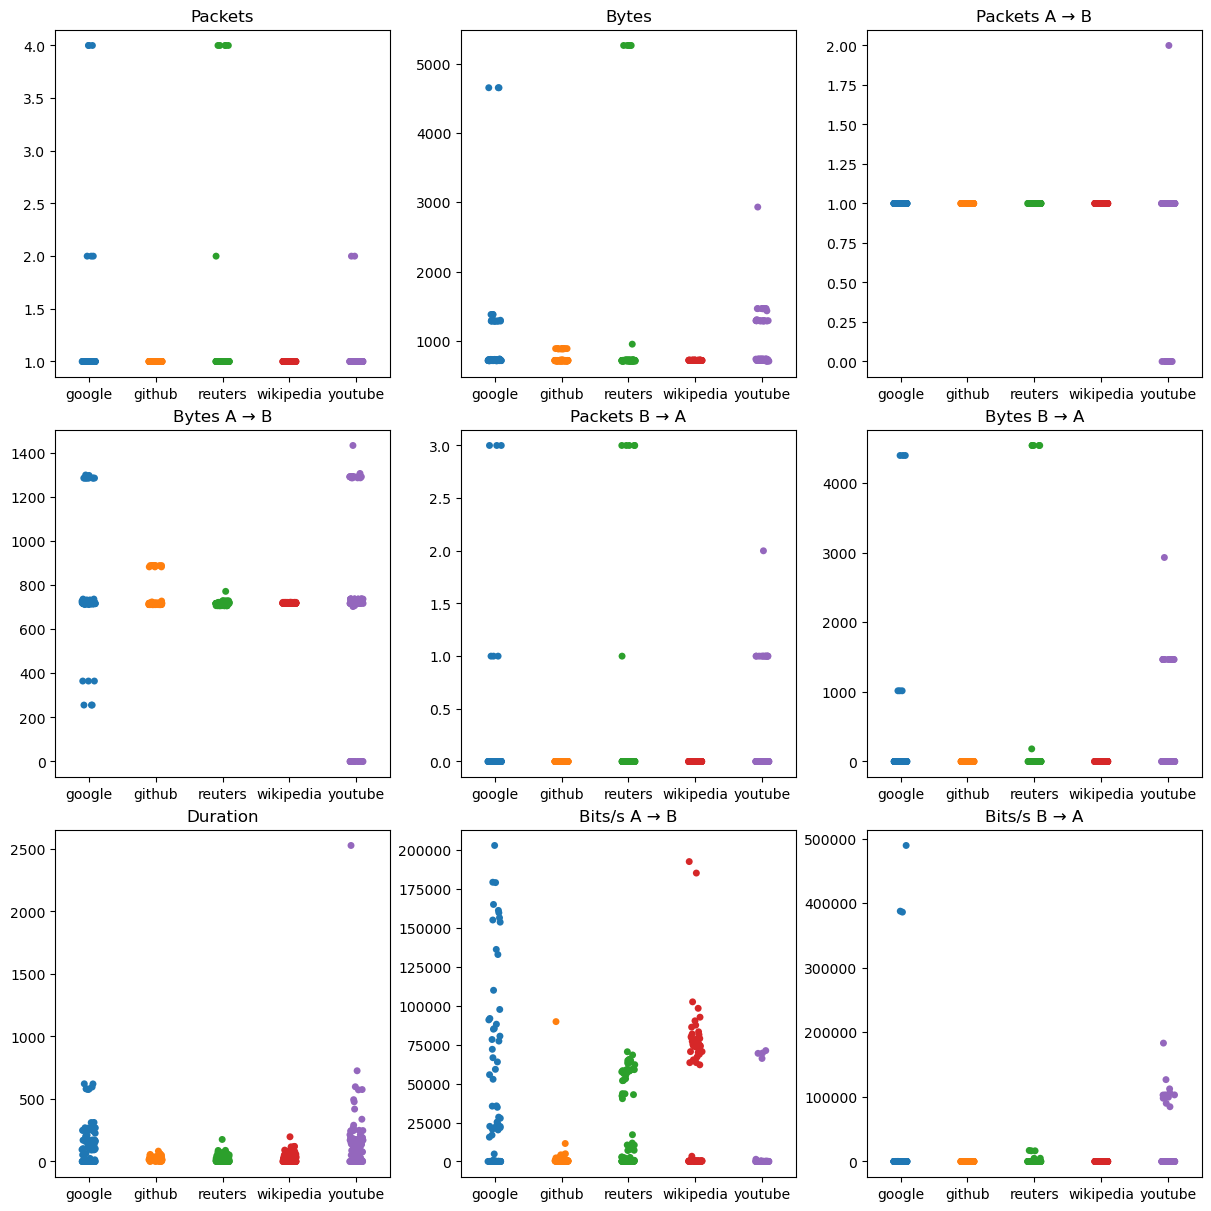

In [22]:
# Comparison of all features across websites
fig, axs = plt.subplots(ncols = 3, nrows = 3, constrained_layout=True)
axX = 0
axY = 0

for feature in features:
    test = pd.concat([google[feature], github[feature], reuters[feature], wikipedia[feature], youtube[feature]], axis = 1)
    test.columns = ["google", "github", "reuters", "wikipedia", "youtube"]
    
    # Strip plot of features
    sns.stripplot(data = test, ax = axs[axY][axX])
    axs[axY][axX].set_title("{}".format(feature))
    
    axX += 1
    if (axX == 3):
        axX = 0
        axY += 1
    if (axY == 3):
        axY = 0

fig.set_size_inches(12, 12)